<a href="https://colab.research.google.com/github/RishabhNegi1/Research_Link_Prediction/blob/main/Links_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Processing chunk 1
[LightGBM] [Info] Number of positive: 21608, number of negative: 21608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 43216, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

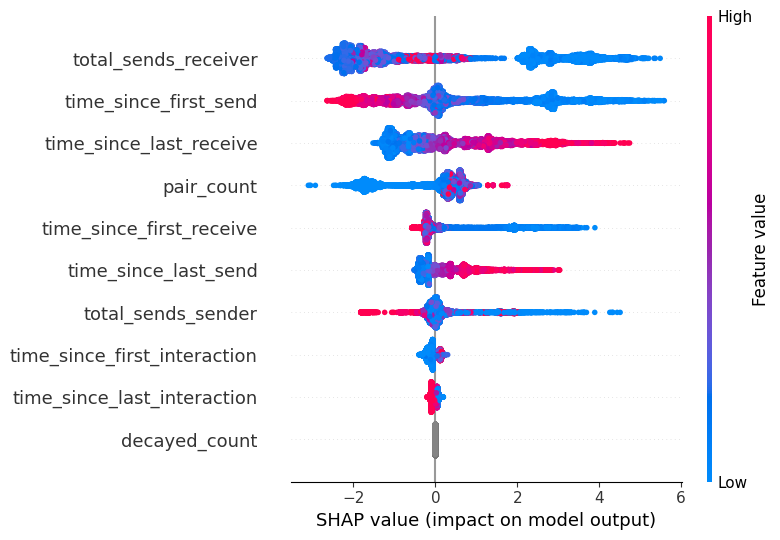

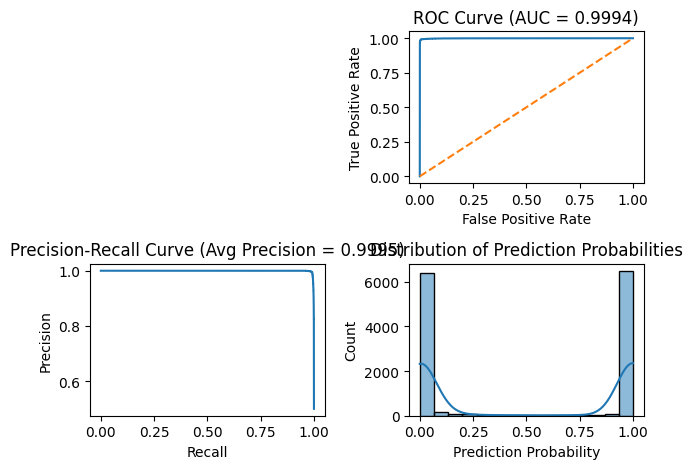

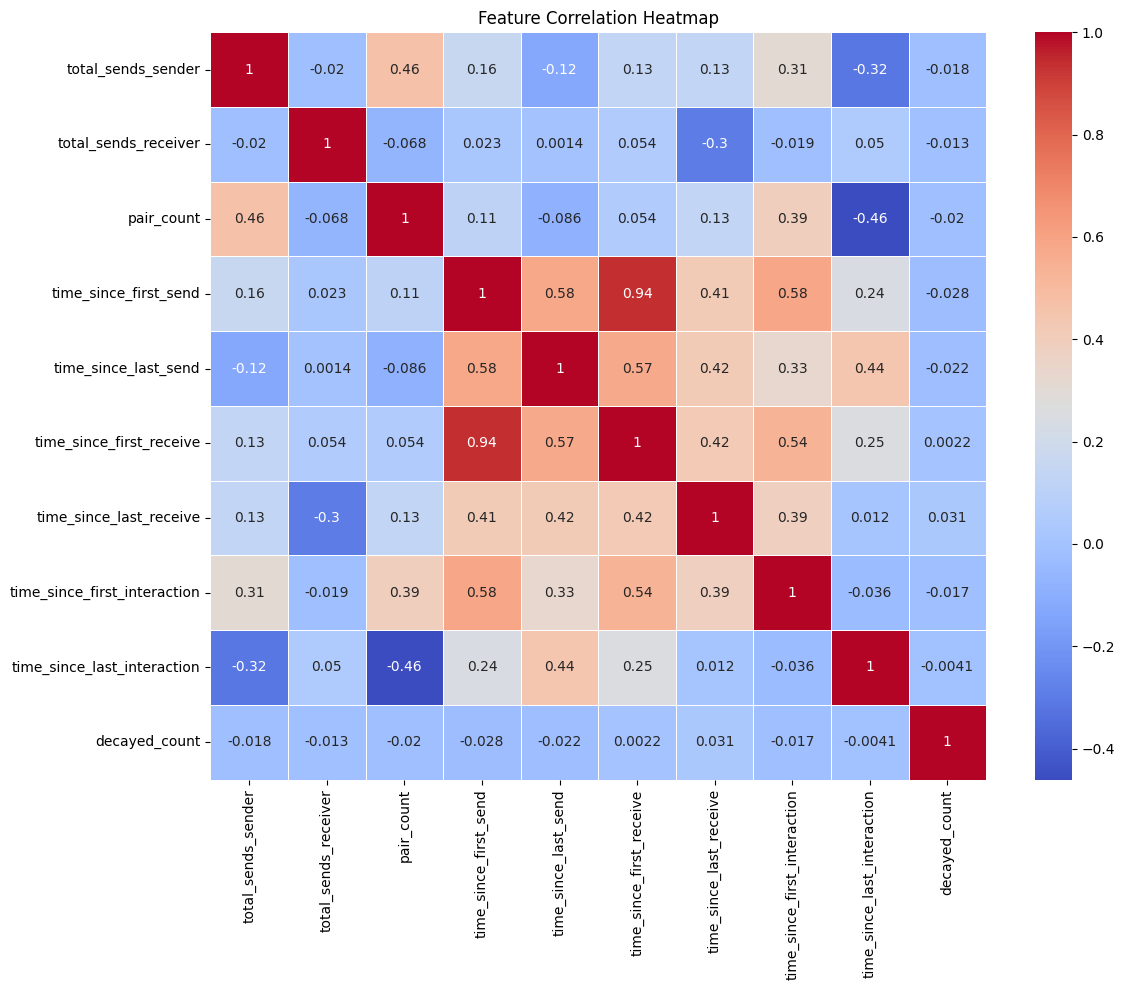

<Figure size 1500x1500 with 0 Axes>

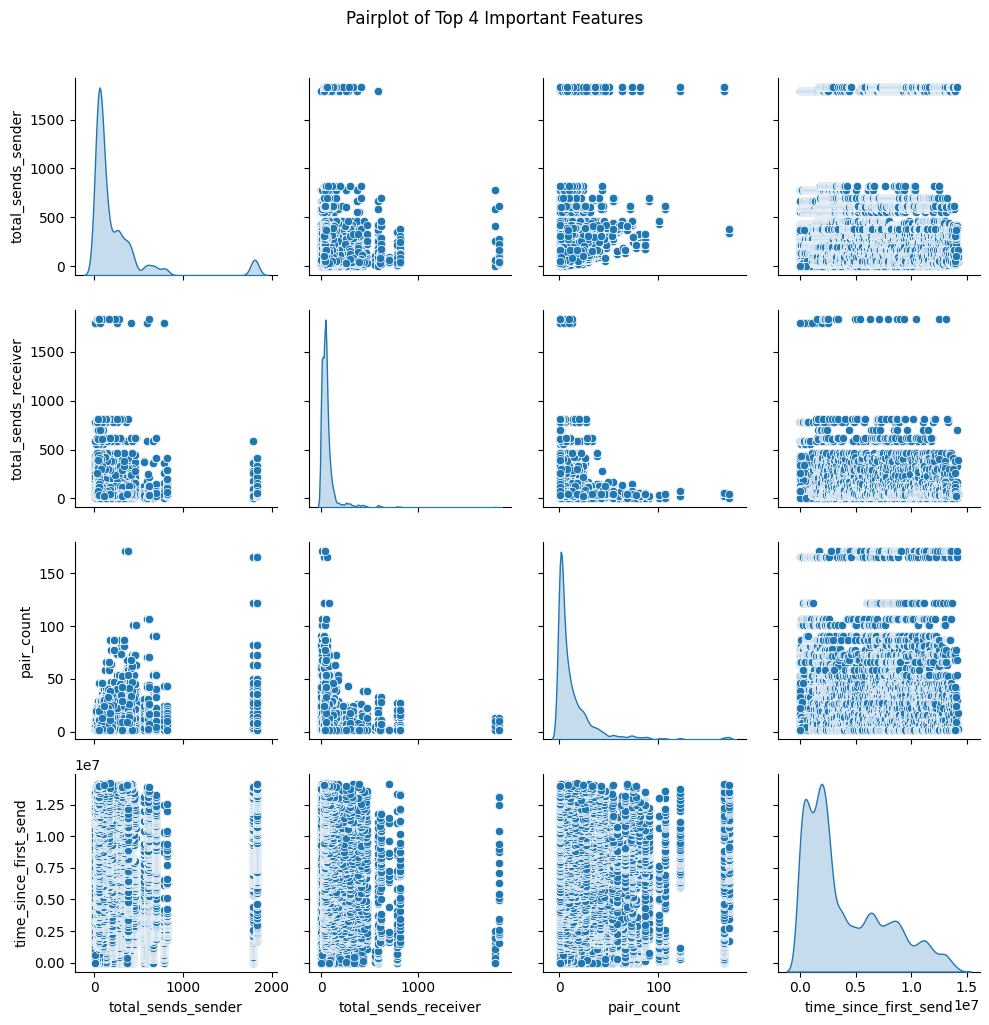

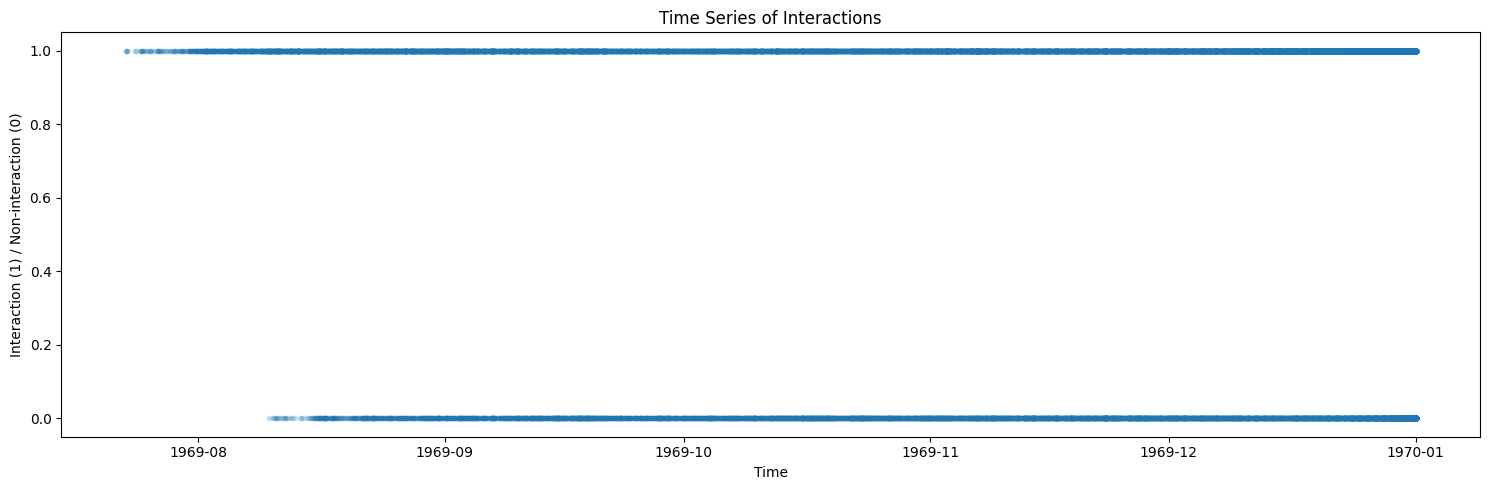

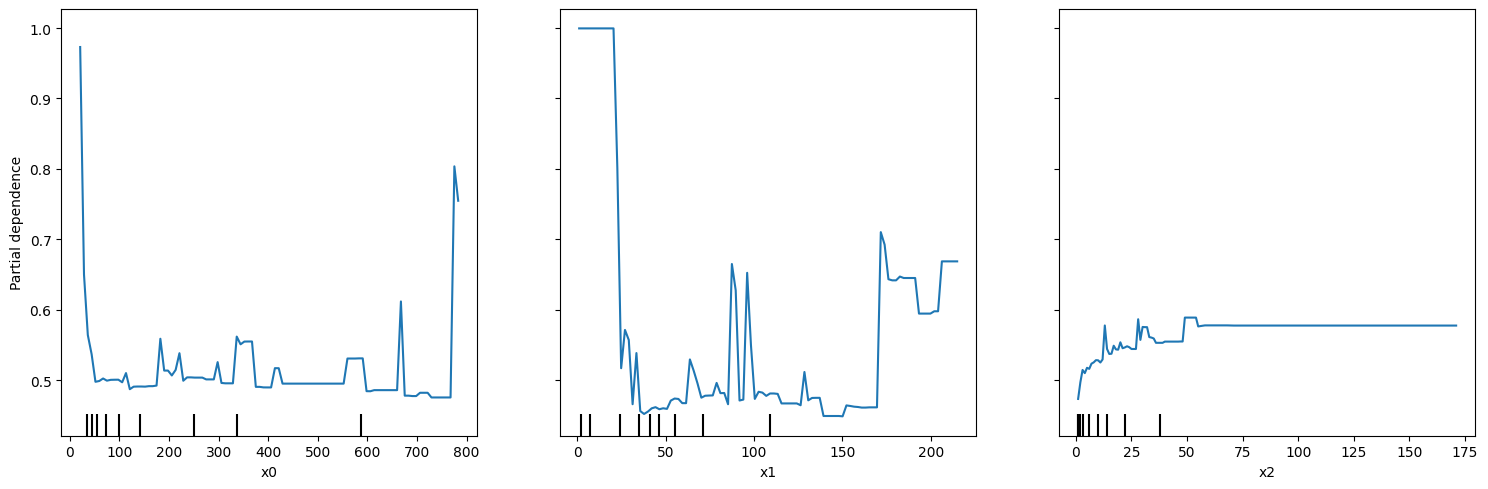

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay
import shap

# Function to read data in chunks
def read_data_in_chunks(file_path, chunk_size=100000):
    return pd.read_csv(file_path, sep='\s+', header=None,
                       names=['sender', 'receiver', 'timestamp'],
                       chunksize=chunk_size)

# Function to create features for a chunk of data
def create_features(df):
    df = df.sort_values('timestamp')

    user_activity = df.groupby('sender').agg({
        'timestamp': ['count', 'min', 'max']
    }).reset_index()
    user_activity.columns = ['user', 'total_sends', 'first_send', 'last_send']

    pair_activity = df.groupby(['sender', 'receiver']).agg({
        'timestamp': ['count', 'min', 'max']
    }).reset_index()
    pair_activity.columns = ['sender', 'receiver', 'pair_count', 'first_interaction', 'last_interaction']

    df = pd.merge(df, user_activity.rename(columns={'user': 'sender'}), on='sender', how='left')
    df = pd.merge(df, user_activity.rename(columns={'user': 'receiver'}), on='receiver', how='left', suffixes=('_sender', '_receiver'))
    df = pd.merge(df, pair_activity, on=['sender', 'receiver'], how='left')

    df['time_since_first_send'] = df['timestamp'] - df['first_send_sender']
    df['time_since_last_send'] = df['timestamp'] - df['last_send_sender']
    df['time_since_first_receive'] = df['timestamp'] - df['first_send_receiver']
    df['time_since_last_receive'] = df['timestamp'] - df['last_send_receiver']
    df['time_since_first_interaction'] = df['timestamp'] - df['first_interaction']
    df['time_since_last_interaction'] = df['timestamp'] - df['last_interaction']

    decay_factor = 0.99
    df['decayed_count'] = df.groupby('sender')['timestamp'].apply(
        lambda x: (decay_factor ** (df['timestamp'].max() - x)).sum())

    return df

# Function to create negative samples
def create_negative_samples(df, n_samples):
    all_users = pd.concat([df['sender'], df['receiver']]).unique()
    neg_samples = pd.DataFrame({
        'sender': np.random.choice(all_users, n_samples),
        'receiver': np.random.choice(all_users, n_samples),
        'timestamp': df['timestamp'].sample(n_samples, replace=True).values
    })
    neg_samples = neg_samples[neg_samples['sender'] != neg_samples['receiver']]
    neg_samples = neg_samples[~neg_samples.set_index(['sender', 'receiver']).index.isin(
        df.set_index(['sender', 'receiver']).index
    )]
    return neg_samples

# Main processing function
def process_data(file_path):
    features = []
    labels = []
    chunk_reader = read_data_in_chunks(file_path)

    for i, chunk in enumerate(chunk_reader):
        print(f"Processing chunk {i+1}")
        pos_features = create_features(chunk)
        n_pos = len(pos_features)

        neg_samples = create_negative_samples(chunk, n_pos)
        neg_features = create_features(pd.concat([chunk, neg_samples]).reset_index(drop=True))
        neg_features = neg_features.iloc[n_pos:]

        chunk_features = pd.concat([pos_features, neg_features])
        chunk_labels = np.concatenate([np.ones(n_pos), np.zeros(len(neg_features))])

        features.append(chunk_features)
        labels.append(chunk_labels)

        del pos_features, neg_samples, neg_features, chunk_features
        gc.collect()

    return pd.concat(features), np.concatenate(labels)

# Load and process data
file_path = '/content/fb-forum (1).txt'  # Update this with the actual path to your data file
X, y = process_data(file_path)

# Select features for the model
feature_cols = ['total_sends_sender', 'total_sends_receiver', 'pair_count',
                'time_since_first_send', 'time_since_last_send',
                'time_since_first_receive', 'time_since_last_receive',
                'time_since_first_interaction', 'time_since_last_interaction', 'decayed_count']
X = X[feature_cols]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# Build a stacking classifier with advanced models
estimators = [
    ('xgb', XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)),
    ('lgbm', LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_samples=20,
        min_split_gain=1e-3,
        random_state=42
    )),
    ('catboost', CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False))
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier())

# Cross-validation
cv_scores = cross_val_score(stacking_clf, X_train_res, y_train_res, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Fit the stacking classifier
stacking_clf.fit(X_train_res, y_train_res)

# Model Calibration
calibrated_clf = CalibratedClassifierCV(stacking_clf, method='isotonic')
calibrated_clf.fit(X_train_res, y_train_res)

# Make predictions
y_pred_proba = calibrated_clf.predict_proba(X_test_imputed)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

# Feature importance using SHAP
explainer = shap.Explainer(stacking_clf.named_estimators_['xgb'])
shap_values = explainer(X_test_imputed)

# Plotting
plt.figure(figsize=(20, 15))

# 1. SHAP summary plot
shap.summary_plot(shap_values, X_test)

# 2. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.4f})')

# 3. Precision-Recall Curve
plt.subplot(2, 2, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.4f})')

# 4. Distribution of Prediction Probabilities
plt.subplot(2, 2, 4)
sns.histplot(y_pred_proba, kde=True)
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.title('Distribution of Prediction Probabilities')

plt.tight_layout()
plt.show()

# 5. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# 6. Pairplot of Top 4 Important Features
top_features = feature_cols[:4]
plt.figure(figsize=(15, 15))
sns.pairplot(X[top_features], diag_kind='kde')
plt.suptitle('Pairplot of Top 4 Important Features', y=1.02)
plt.tight_layout()
plt.show()

# 7. Time Series of Interactions
plt.figure(figsize=(15, 5))
plt.plot(pd.to_datetime(X['time_since_last_interaction'], unit='s'), y, '.', alpha=0.1)
plt.xlabel('Time')
plt.ylabel('Interaction (1) / Non-interaction (0)')
plt.title('Time Series of Interactions')
plt.tight_layout()
plt.show()

# 8. Partial Dependence Plots
fig, ax = plt.subplots(figsize=(15, 5))
PartialDependenceDisplay.from_estimator(stacking_clf, X_test_imputed, features=[0, 1, 2], ax=ax)
plt.tight_layout()
plt.show()